In [1]:
import os
import sys
import time
from datetime import datetime
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from model_settings import ms
jupyter_dir = os.path.abspath(str(Path()))
os.chdir(jupyter_dir)
sys.path.append(os.path.join(jupyter_dir,'train_data'))
sys.path.append(os.path.join(
    jupyter_dir,
    'historical_data',
    'historical_generation'))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format

train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')

print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual


##################
# training start #
##################

Fri Oct 11 11:07:17 2024



# Loading data


importing dataset(s)...



loading: 100%|█████████████████████████████████████████████████████████████████████| 1234/1234 [00:21<00:00, 56.71it/s]



preparing data...


         spot_price  strike_price       barrier  days_to_maturity  \
count 6701513.00000 6701513.00000 6701513.00000     6701513.00000   
mean     1235.87235    1235.12673    1235.95857         329.00363   
min       676.03000     608.42700     338.01500          60.00000   
25%       920.17000     941.36547     860.60080          90.00000   
50%      1331.14000    1317.30518    1186.47108         360.00000   
75%      1466.84000    1450.39245    1558.88625         540.00000   
max      1565.18000    1721.69800    2347.77000         720.00000   
std       263.93839     273.65950     471.51758         241.55227   

       barrier_price        rebate  dividend_rate  risk_free_rate  \
count  6701513.00000 6701513.00000  6701513.00000   6701513.00000   
mean        53.48514       0.00000        0.02324         0.04000   
min          0.00000       0.00000        0.01780         0.04000   
25%          3.57453       0.00000        0.01914         0.04000   
50%         

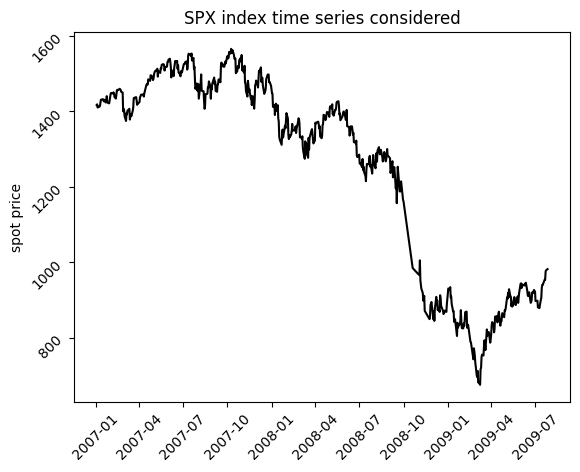

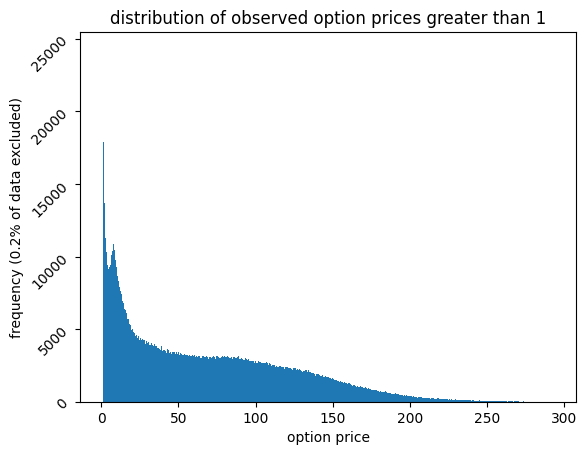

<Figure size 640x480 with 0 Axes>

In [2]:
from HDF_collection import contracts
dataset = contracts.copy()

# Preprocessing

In [3]:
from convsklearn import barrier_trainer
bt = barrier_trainer

test size: 1.0%
random state: None
maximum iterations: 1000

target: 
observed_price

features: 
['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier', 'barrier_type_name', 'w']

feature transformer(s):
('StandardScaler', StandardScaler(), ['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier'])

('OneHotEncoder', OneHotEncoder(sparse_output=False), ['barrier_type_name', 'w'])

target transformer(s):
StandardScaler()



In [4]:
"""
manual train/test split
"""
unique_dates = dataset['calculation_date'].sort_values(
    ascending=True).unique().tolist()
filter_date = unique_dates[int(0.85*len(unique_dates))]

train_data = dataset[
    (
      # (dataset['calculation_date']>=datetime(2007,1,1))
      #  &
        (dataset['calculation_date']<=filter_date)
      )].copy()

test_data = dataset[
    (
      (dataset['calculation_date']>filter_date)
      # &
      # (dataset['calculation_date']<=datetime(2012,12,31))
      )].copy()



In [5]:
"""
preprocessing
"""
train_X, train_y, test_X, test_y = bt.get_train_test_arrays(
    train_data, test_data)
preprocessor = bt.preprocess()
train_startdate = train_data.describe()['calculation_date']['min'].strftime('%A, %Y-%m-%d')
train_enddate = train_data.describe()['calculation_date']['max'].strftime('%A, %Y-%m-%d')
print(f"\ntraining from\n{train_startdate}\nto\n{train_enddate}\n")


training from
Wednesday, 2007-01-03
to
Monday, 2009-03-16



In [6]:
print(f"\n{train_data.dtypes}")
test_train_ratio = test_data.describe(
    ).iloc[0,0]/train_data.describe().iloc[0,0]

print(f"\ntrain/test: {int(round((1-test_train_ratio)*100,0))}/"
      +str(int(round(test_train_ratio*100,0))))


spot_price                  float64
strike_price                float64
barrier                     float64
days_to_maturity              int64
barrier_price               float64
updown                       object
outin                        object
w                            object
barrier_type_name            object
rebate                      float64
dividend_rate               float64
risk_free_rate              float64
theta                       float64
kappa                       float64
rho                         float64
eta                         float64
v0                          float64
calculation_date     datetime64[ns]
expiration_date      datetime64[ns]
moneyness                   float64
observed_price              float64
dtype: object

train/test: 81/19


# Training

In [7]:
model_fit, runtime, specs = bt.run_dnn(preprocessor,train_X,train_y)
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")


training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

cpu: 1074.2937734127045


# Testing

In [8]:
test_data.describe()

,spot_price,strike_price,barrier,days_to_maturity,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,expiration_date,moneyness,observed_price
count,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938.00000,1072938,1072938,1072938.00000,1072938.00000
mean,887.68808,887.48183,888.50826,326.36003,47.97380,0.00000,0.02595,0.04000,0.10217,5.45734,-0.99694,0.20389,0.08528,2009-05-21 04:58:31.038288896,2010-04-12 13:36:57.801960960,2.04715,47.97937
min,768.06000,691.25400,384.03000,60.00000,0.00000,0.00000,0.02312,0.04000,0.07061,2.05280,-1.00000,0.15451,0.03432,2009-03-17 00:00:00,2009-05-16 00:00:00,-0.94447,0.00000
25%,852.08000,836.78527,665.29990,90.00000,4.75317,0.00000,0.02449,0.04000,0.08299,4.81159,-1.00000,0.18654,0.05626,2009-04-17 00:00:00,2009-09-08 00:00:00,-0.74477,4.75656
50%,897.78000,886.40200,894.34620,360.00000,32.48536,0.00000,0.02525,0.04000,0.08905,5.45924,-0.99999,0.19969,0.07300,2009-05-20 00:00:00,2010-03-13 00:00:00,-0.02777,32.48582
75%,920.98000,940.16314,1120.80287,540.00000,82.76780,0.00000,0.02729,0.04000,0.12506,5.95634,-0.99995,0.22177,0.11379,2009-06-23 00:00:00,2010-11-12 00:00:00,1.81783,82.76201
max,982.26000,1080.48600,1473.39000,720.00000,210.76771,0.00000,0.03065,0.04000,0.15119,8.79712,-0.92557,0.26985,0.17432,2009-07-27 00:00:00,2011-07-17 00:00:00,17.00810,210.73042
std,49.20677,71.63728,280.95267,241.41312,48.33416,0.00000,0.00186,0.00000,0.02452,1.19190,0.01159,0.02609,0.03675,NaN,NaN,4.40482,48.32886


In [9]:
insample, outsample, errors = bt.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
        )


in sample:
     RSME: 5.300018231041974
     MAE: 3.6417148946720896

out of sample:
     RSME: 6.967977780414362
     MAE: 5.023559701383556


# Saving

In [10]:
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H-%M-%S"))
file_tag = str(train_end_tag + " " + specs[0] )
os.chdir(os.path.join(jupyter_dir,'trained_models'))
files_dir = os.path.join(
    jupyter_dir,'trained_models','trained_models',
    file_tag)

if Path(files_dir).exists():
    pass
else:
    os.mkdir(files_dir)

file_dir = os.path.join(files_dir,file_tag)

S = np.sort(train_data['spot_price'].unique())
K = np.sort(train_data['strike_price'].unique())
T = np.sort(train_data['days_to_maturity'].unique())
W = np.sort(train_data['w'].unique())
n_calls = train_data[train_data['w']=='call'].shape[0]
n_puts = train_data[train_data['w']=='put'].shape[0]
insample.to_csv(f"{file_dir} insample.csv")
outsample.to_csv(f"{file_dir} outsample.csv")
joblib.dump(model_fit,str(f"{file_dir}.pkl"))
pd.set_option("display.max_columns",None)
with open(f'{file_dir}.txt', 'w') as file:
    file.write(train_start_tag)
    file.write(f"\nspot(s):\n{S}")
    file.write(f"\n\nstrikes:\n{K}\n")
    file.write(f"\nmaturities:\n{T}\n")
    file.write(f"\ntypes:\n{W}\n")
    try:
        file.write(f"\n{train_data['barrier_type_name'].unique()}")
    except Exception:
        pass
    file.write("")
    file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
    file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")
    for spec in specs:
        file.write(f"{spec}\n")
    file.write("#"*17+"\n# training data #\n"+"#"*17+
          f"\n{train_data.describe()}\n")
    file.write("#"*13+"\n# test data #\n"+"#"*13+
          f"\n{test_data.describe()}\n")
    file.write(f"\n{dataset.dtypes}")
    file.write(
        f"\nin sample results:"
        f"\n     RMSE: {errors['insample_RMSE']}"
        f"\n     MAE: {errors['insample_MAE']}\n"
        f"\nout of sample results:"
        f"\n     RMSE: {errors['outofsample_RMSE']}"
        f"\n     MAE: {errors['outofsample_MAE']}\n"
        )
    file.write("\nfeatures:\n")
    for feature in bt.feature_set:
        file.write(f"     {feature}\n")
    file.write(f"\ntarget: {bt.target_name}\n")
    file.write(f"\ncpu: {train_runtime}\n")
    file.write(datetime.fromtimestamp(train_end).strftime('%c'))